<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2024notebooks/2024_115Karapetian_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Karapetian+ (2023), Empirically Identifying and Computationally Modeling the Brain–Behavior Relationship for Human Scene Categorization, Journal of Cognitive Neuroscience 35:11, pp. 1879–1897, doi:10.1162/jocn_a_02043

データは，https://osf.io/4fdky/ より入手して，駒澤 Gdrive で共有

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'device:{device}')

import os
import numpy as np
import sys
import zipfile
import glob

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

if isColab:
    from google.colab import drive
    drive.mount('/content/drive')

    basedir = '/content/drive/Shareddrives/#2024認知心理学研究(1)b/浅川先生/2023Karapetian+OSF'
    fnames = list(sorted(glob.glob(os.path.join(basedir,'Stimuli/*.jpg'))))
else:
    HOME = os.environ['HOME']
    basedir = os.path.join(HOME, 'study/2024Agnessa14_Perceptual-decision-making.git/Stimuli')
    fnames = list(sorted(glob.glob(os.path.join(basedir,'*.jpg'))))

import matplotlib.pyplot as plt
import PIL

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

device:cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 刺激画像の表示

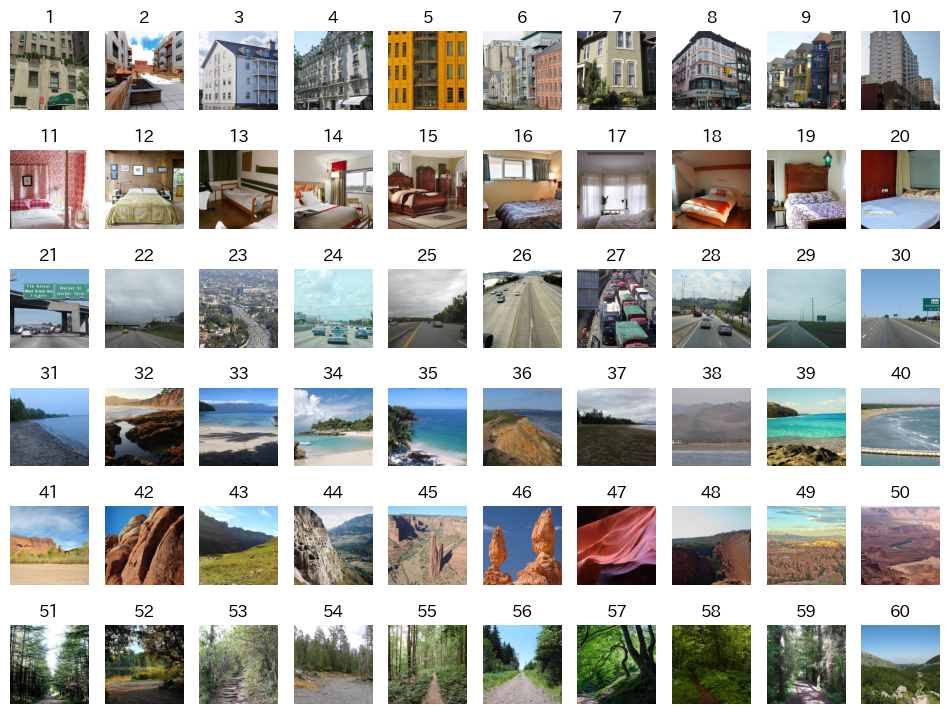

In [4]:
# 刺激画像の表示
nrows, ncols = 6, 10
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,9))
#fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,10))

i=0
for row in range(nrows):
    for col in range(ncols):
        img = PIL.Image.open(os.path.join(basedir, 'Stimuli/'+str(i+1)+'.jpg')).convert('RGB')
        ax[row][col].imshow(img)
        ax[row][col].axis('off')
        ax[row][col].set_title(f'{i+1}')
        i += 1

# 1-10: アパート
#11-20: ベッド
#21-30: 高速道路
#31-40: 海岸
#41-50: 峡谷
#51-60: 森林
# 1-30 は，人工物情景であり，31-60 は，自然情景

# 画像を相関係数行列として可視化


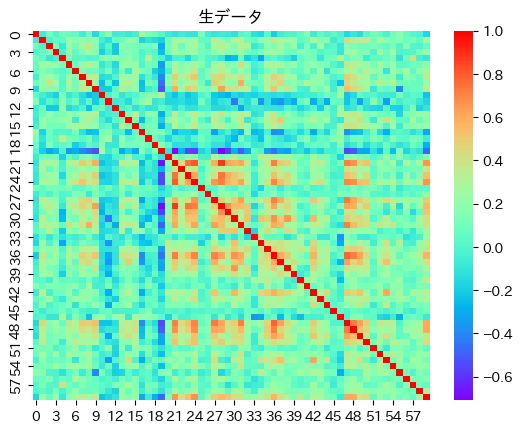

In [5]:
# 画像を相関係数行列として可視化
import seaborn
Imgs = []
for i in range(1,61):
    img = PIL.Image.open(os.path.join(basedir, 'Stimuli/'+str(i)+'.jpg'))
    x = np.array(img)
    Imgs.append(x.reshape(-1))

R_img = np.corrcoef(np.array(Imgs))
cmap = 'seismic'
cmap = 'rainbow'
ax = plt.axes()
seaborn.heatmap(R_img, ax=ax, cmap=cmap)
ax.set_title('生データ')
plt.show()

# 深層学習モデルの出力を相関係数行列として可視化


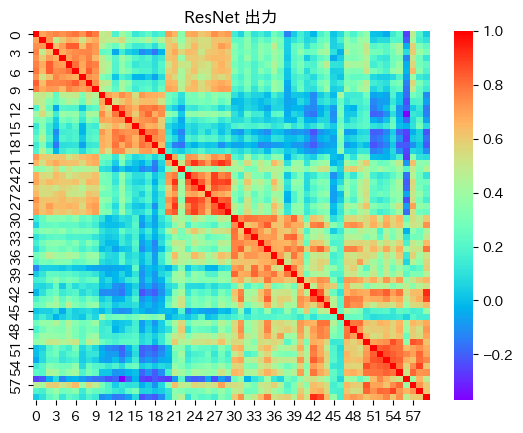

In [6]:
# 深層学習モデルの出力を相関係数行列として可視化
import torchvision.models as models
from torchvision import transforms

Img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

model = models.resnet18(weights="DEFAULT") # .double()

model.eval()
outputs = []
for i in range(1,61):
    img = PIL.Image.open(os.path.join(basedir, 'Stimuli', str(i)+'.jpg')).convert('RGB')
    _img = Img_transform(img)
    out = model(_img.unsqueeze(0))
    outputs.append(out.detach().numpy()[0])

R_out = np.corrcoef(np.array(outputs))

ax = plt.axes()
seaborn.heatmap(R_out, ax=ax, cmap=cmap)
ax.set_title('ResNet 出力')
plt.show()

# 深層モデルの詳細

In [14]:
# print(model.eval())
# print(f'model.layer4:{model.layer4}')
# print(f'model.avgpool:{model.avgpool}')
# print(f'model.fc:{model.fc}')

## 深層モデルの各層ごとに特徴を取り出す準備

In [7]:
model = models.resnet18(weights="DEFAULT") # .double()
model = models.resnet50(weights="DEFAULT") # .double()

_avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
l1_data = []
def get_layer1_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l1_data.append(tmp.reshape(-1))

l2_data = []
def get_layer2_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l2_data.append(tmp.reshape(-1))

l4_data = []
def get_layer4_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l4_data.append(tmp.reshape(-1))

l3_data = []
def get_layer3_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l3_data.append(tmp.reshape(-1))


fc_data = []
def get_fc_output(module, input, output):
    fc_data.append(output.data.detach().cpu().numpy()[0])

#features = ['layer4', 'fc']
model.fc.register_forward_hook(get_fc_output)
model.layer1.register_forward_hook(get_layer1_output)
model.layer2.register_forward_hook(get_layer2_output)
model.layer3.register_forward_hook(get_layer3_output)
model.layer4.register_forward_hook(get_layer4_output)

model.eval()
outputs = []
for i in range(1,61):
    img = PIL.Image.open(os.path.join(basedir, 'Stimuli', str(i)+'.jpg')).convert('RGB')
    _img = Img_transform(img)
    out = model(_img.unsqueeze(0))
    outputs.append(out.detach().numpy()[0])


print(len(fc_data), np.array(fc_data).shape)
R_L1 = np.corrcoef(np.array(l1_data))
R_L2 = np.corrcoef(np.array(l2_data))
R_L3 = np.corrcoef(np.array(l3_data))
R_L4 = np.corrcoef(np.array(l4_data))
R_fc = np.corrcoef(np.array(fc_data))

60 (60, 1000)


## 各層ごとの刺激画像間の相関係数行列 (RDM)

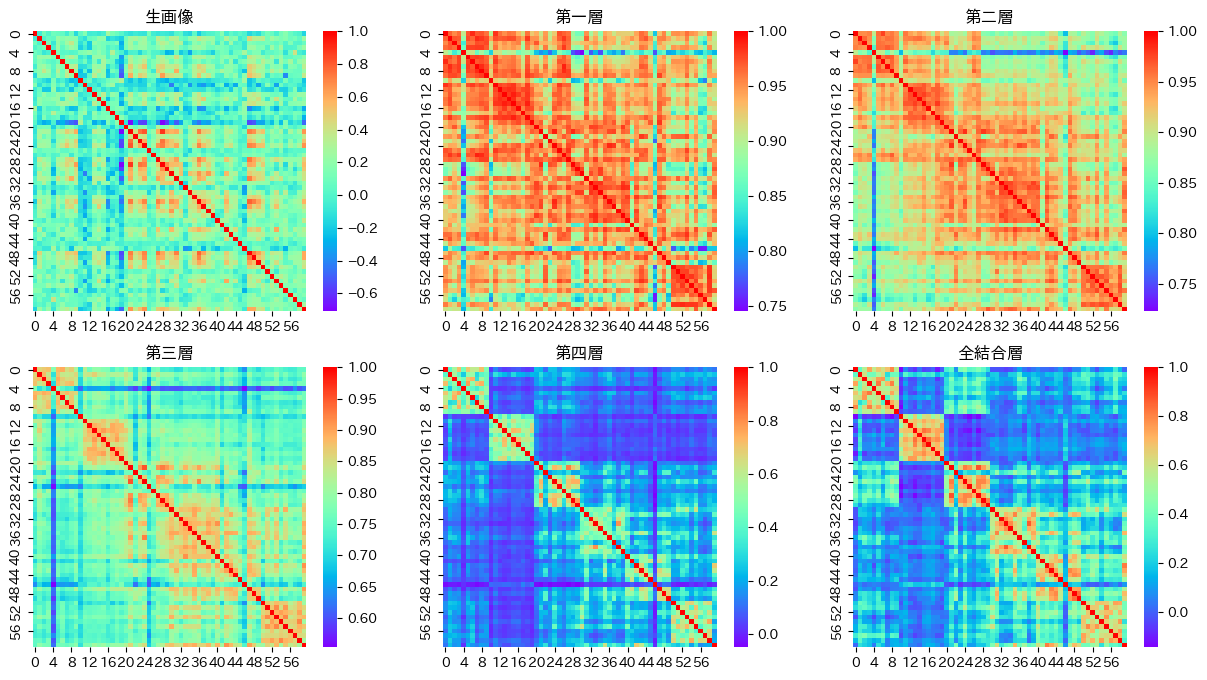

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
i, row, col = 0, 0, 0
for _title, _R in [('生画像', R_img), ('第一層', R_L1), ('第二層', R_L2),
                   ('第三層', R_L3), ('第四層', R_L4), ('全結合層', R_fc)]:
    seaborn.heatmap(_R, cmap=cmap, ax=axes[row][col])
    axes[row][col].set_title(_title)

    col += 1
    if col > 2:
        col = 0
        row += 1

plt.show()

## 機械学習による判別

In [8]:
import numpy as np
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 教師信号の作成
Tch = np.array([1 for i in range(30)] + [0 for i in range(30)])
models = [KMeans(), LDA(), SVC(), LogReg()]
for model in models:
    print(model.__doc__.split('\n')[:2])
    for D in [Imgs, l1_data, l2_data, l3_data, l4_data]:
        _X, _y = np.array(D), Tch
        _X, _test, _y, _test_y = train_test_split(_X, Tch, test_size=0.2)
        model.fit(_X, _y)
        print(f'予測:{model.predict(_test)}',
              f'正解:{_test_y}')

['K-Means clustering.', '']
予測:[4 4 1 6 6 1 6 4 6 2 4 6] 正解:[0 0 1 1 1 1 0 0 0 1 1 0]
予測:[7 3 6 6 2 2 2 3 2 7 3 3] 正解:[1 0 0 0 1 1 1 0 1 0 1 1]
予測:[5 6 5 3 4 3 5 5 1 4 5 5] 正解:[1 0 1 0 0 0 1 1 1 0 1 1]
予測:[6 0 4 6 0 4 5 4 0 0 0 6] 正解:[1 0 1 1 0 1 0 1 0 0 0 1]
予測:[2 2 4 6 4 2 3 6 2 6 2 6] 正解:[0 0 1 1 1 0 1 1 0 1 0 1]
['Linear Discriminant Analysis.', '']
予測:[1 1 1 1 0 0 1 1 1 1 1 0] 正解:[0 1 0 0 0 0 0 1 1 0 0 1]
予測:[1 1 0 0 0 1 0 0 0 1 0 0] 正解:[1 1 0 0 0 1 0 0 1 1 0 0]
予測:[0 1 1 0 0 0 1 0 1 1 1 1] 正解:[0 1 1 0 0 0 1 0 1 1 1 1]
予測:[0 0 0 1 1 0 0 1 1 0 1 0] 正解:[0 0 0 1 1 0 0 1 1 0 1 0]
予測:[0 0 1 0 1 0 1 1 0 1 1 1] 正解:[0 0 1 0 1 0 1 1 0 1 1 1]
['C-Support Vector Classification.', '']
予測:[0 0 0 0 0 1 0 0 0 0 0 0] 正解:[1 0 0 1 1 1 1 1 0 1 1 1]
予測:[1 1 0 1 1 1 0 1 0 1 0 1] 正解:[1 0 0 1 1 0 0 0 0 0 0 1]
予測:[0 1 0 1 1 0 1 0 0 1 0 0] 正解:[0 1 0 1 1 0 1 0 0 1 0 0]
予測:[1 1 0 1 1 0 0 1 0 1 1 0] 正解:[1 1 0 1 1 0 0 1 0 1 1 0]
予測:[1 1 1 1 1 1 1 0 0 1 1 1] 正解:[1 1 1 1 1 1 1 0 0 1 1 0]
['', '    Logistic Regr

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 各層ごとに刺激画像の関係を視覚化 PCA

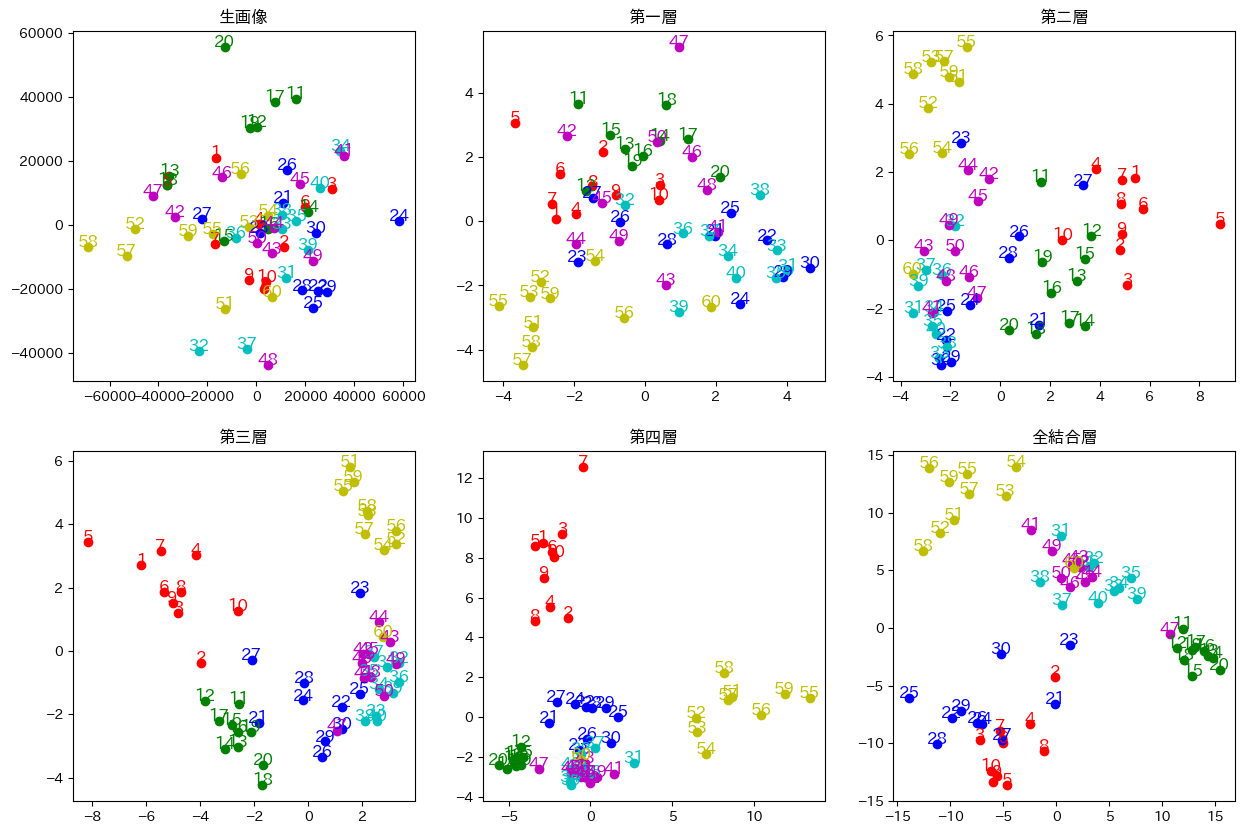

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
colors = ['r','g', 'b', 'c', 'm', 'y']
fontsize=12
i, row, col = 0, 0, 0
for _title, D in [('生画像', Imgs), ('第一層', l1_data), ('第二層', l2_data),
                   ('第三層', l3_data), ('第四層', l4_data), ('全結合層', fc_data)]:
    pca = PCA(n_components=2)
    A = pca.fit(np.array(D))
    A2 = pca.transform(D)
    for idx, z in enumerate(A2):
        color = colors[int(idx / 10)]
        axes[row][col].scatter(z[0], z[1], c=color)
        axes[row][col].annotate(str(idx+1), (z[0], z[1]), ha='center', fontsize=fontsize, c=color)
    axes[row][col].set_title(_title)

    col += 1
    if col > 2:
        col = 0
        row += 1


# 各層ごとに刺激画像の関係を視覚化 tSNE

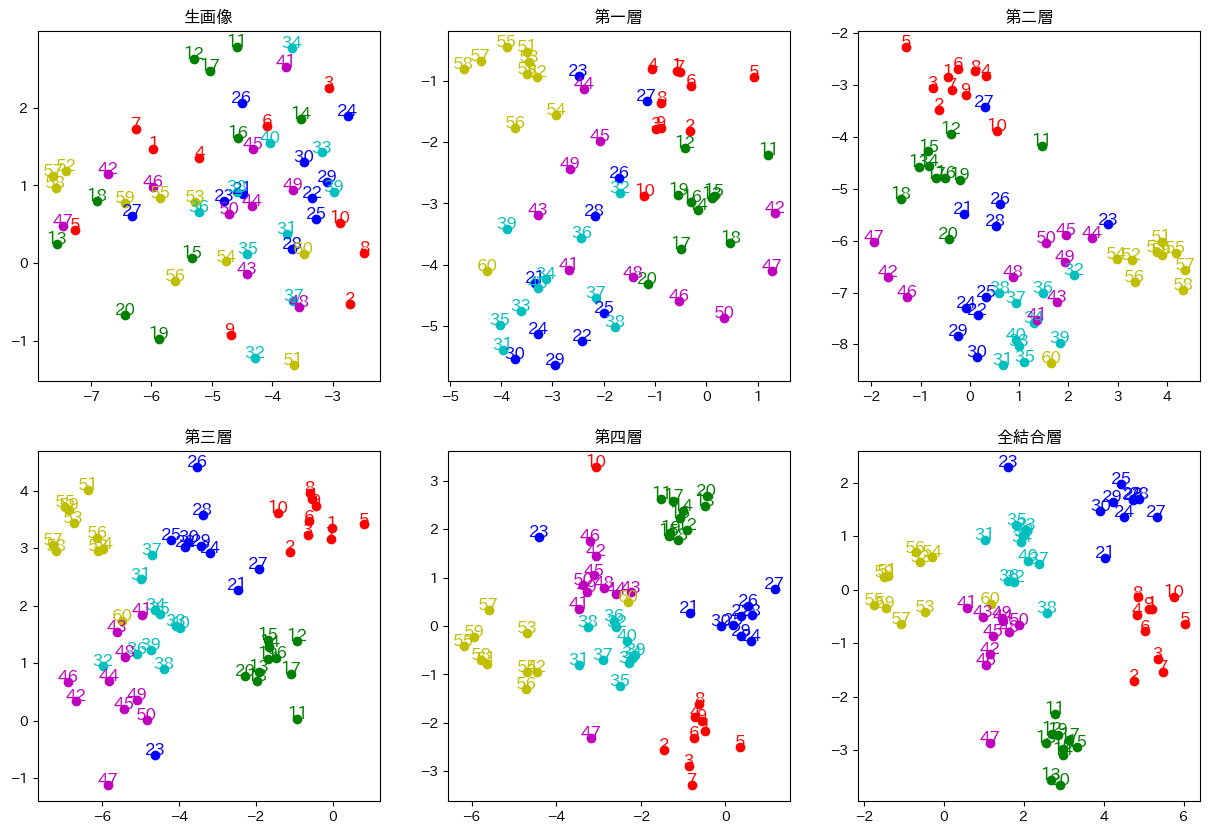

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
colors = ['r','g', 'b', 'c', 'm', 'y']
fontsize=12
row, col = 0, 0
for _title, D in [('生画像', Imgs), ('第一層', l1_data), ('第二層', l2_data),
                   ('第三層', l3_data), ('第四層', l4_data), ('全結合層', fc_data)]:

    A2 = TSNE().fit_transform(np.array(D))
    for idx, z in enumerate(A2):
        color = colors[int(idx / 10)]
        axes[row][col].scatter(z[0], z[1], c=color)
        axes[row][col].annotate(str(idx+1), (z[0], z[1]), ha='center', fontsize=fontsize, c=color)
    axes[row][col].set_title(_title)
    col += 1
    if col > 2:
        col = 0
        row += 1


# [Karapetian+2023 Github readme.txt](https://github.com/Agnessa14/Perceptual-decision-making/blob/master/README.md)

## readme.txt

この ReadMe は Empirically identifying and computationally modelling the brain-behaviour relationship for human scene categorization プロジェクトの OSF リポジトリの ReadMe である。
原稿で使用されたヒト (N=30) とモデルのデータが含まれている。
<!-- This is a ReadMe for the OSF repository to the project "Empirically identifying and computationally modelling the brain-behaviour relationship for human scene categorization" containing human (N=30) and model data used in the manuscript. -->

### 一般情報<!-- %%% General information %%%-->

注意散漫課題のデータは、後に用語が変更されたため fixation という名前で保存されている。
被験者の名前は，元の記録ファイルとの整合性を保つため，記録された名前 (5:26, 28:35) に従っている。
アップロードされたのは前処理済みのデータのみである。
生データにアクセスするには，遠慮なく agnessakarapetian@gmail.com まで。
<!--The data for the distraction task is saved under the name "fixation" due to a later change in terminology.
The subjects are named according to the names under which they were recorded (5:26, 28:35) to remain consistent with the original recording files.
Only preprocessed data were uploaded; to get access to raw data, don't hesitate to contact agnessakarapetian@gmail.com.   -->

### 前処理済 EEG データ<!-- %%% Preprocessed EEG data %%%--->

EEG データは，Fieldtrip の関数を用いて Matlab 2021a で前処理した。
そのため，前処理されたデータは Matlab の構造体（`timelock_categorization.mat` または `timelock_fixation.mat`）ファイルとして保存され，`timelock.trial` には各試行，電極 (計 63)，時点 (合計 200) の情報が含まれている。
刺激 ID は `timelock.trialinfo` の下にある。
前処理の詳細は原稿を参照。
<!--EEG data were preprocessed in Matlab 2021a using functions from Fieldtrip. The preprocessed data are therefore saved as a Matlab structure (timelock_categorization.mat or timelock_fixation.mat) file and timelock.trial contains information for each trial, electrode (total 63) and time point (total 200).
The stimulus IDs are under timelock.trialinfo. For preprocessing details, please refer to the manuscript.   -->

### 前処理済行動データ<!-- %%% Preprocessed behavioural data %%% -->

被験者レベルの反応時間と課題精度は，EEG データの前処理後の全試行について利用可能である。
各被験者の正しい試行の反応時間は，刺激セットと同じ順序で `Behaviour/All_subjects` にある。
完全な行動データファイルについては，問い合わせてほしい。
<!--Subject-level reaction times and task accuracy are available for all trials that remained after preprocessing the EEG data.
The reaction times for the correct trials for each subject are available in Behaviour/All_subjects, in the same order as in the stimulus set.  
For complete behavioural data files, please get in touch.  -->

### モデル（RCNN）の行動データと重み<!-- %%% Model (RCNN) behavioural data and weights %%%-->

RCNN フォルダには，論文で使用した微調整済 RCNN の重み係数行列がある。
これは，BLnet (Spoerer+2020) であり，econet データセット (Mehrer2017) を用いて訓練し，Places-365 データセット (Zhou+2018) をもちいて微調整した。
シーン分類課題に対するモデルの反応時間を利用可能にし、刺激セットと同じ順序に従う。
<!--The RCNN folder contains weights for the fine-tuned RCNN used in the paper, BLnet (Spoerer et al., 2020), initially trained on ecoset (Mehrer et al., 2017)
but fine-tuned on a subset of Places-365 (Zhou et al., 2018).
The reaction times of the model to the scene categorization task are made available and follow the same order as in the stimulus set.  -->

### 刺激セット<!-- %%% Stimulus set %%%-->

刺激セットは 60 の情景画像で構成され，前半は人工物の情景，後半は自然物情景の画像である。
これらは Places-365 (Zhou+2018) の検証セットから取られ，中央で切り取られ，480x480 にリサイズされた。
オリジナルの画像については、`http://places2.csail.mit.edu/download.html`
<!--The stimulus set consists of 60 scene images: the first half depicts man-made scenes and the second half natural. These were taken from the validation set of Places-365 (Zhou et al., 2018), center-cropped and resized to 480x480.
For original images, please refer to http://places2.csail.mit.edu/download.html.  -->




#  反応時間データの読み込み

RT_subs_cats['RTs'].shape:(30, 60)


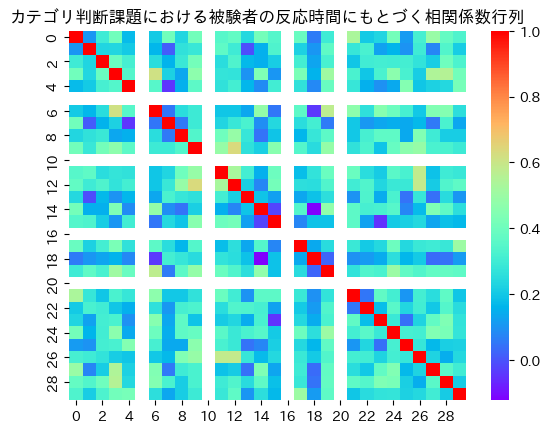

In [12]:
import scipy
import scipy.io

if isColab:
    basedir = "/content/drive/Shareddrives/#2024認知心理学研究(1)b/浅川先生/2023Karapetian+OSF/Behaviour/All_subjects/RTs"
else:
    basedir = os.path.join(HOME, 'study/2024Agnessa14_Perceptual-decision-making.git/Behaviour/All_subjects/RTs')

fname = 'RT_all_subjects_5_35_categorization.mat'
RT_subs_cats = scipy.io.loadmat(os.path.join(basedir, fname))
print(f"RT_subs_cats['RTs'].shape:{RT_subs_cats['RTs'].shape}")

R_cat_subs = np.corrcoef(RT_subs_cats['RTs'])
ax = plt.axes()
seaborn.heatmap(R_cat_subs, ax=ax, cmap=cmap)
ax.set_title('カテゴリ判断課題における被験者の反応時間にもとづく相関係数行列')
#ax.set_title('Categorization RT correlation matrix among subjects')
plt.show()

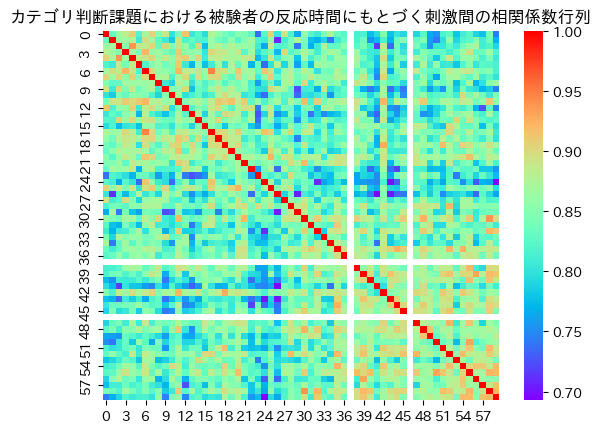

In [14]:
R_cat_stims = np.corrcoef(RT_subs_cats['RTs'].T)
ax = plt.axes()
seaborn.heatmap(R_cat_stims, ax=ax, cmap=cmap)
ax.set_title('カテゴリ判断課題における被験者の反応時間にもとづく刺激間の相関係数行列')
#ax.set_title('Categorization RT correlation matrix among subjects')
plt.show()

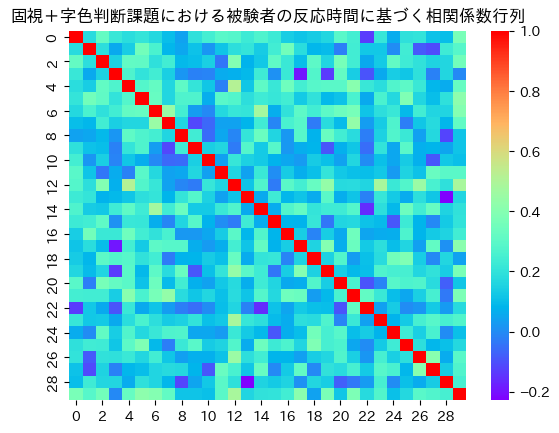

In [15]:
fname = 'RT_all_subjects_5_35_fixation.mat'
RT_destract = scipy.io.loadmat(os.path.join(basedir, fname))

R_destract = np.corrcoef(RT_destract['RTs'])
ax = plt.axes()
seaborn.heatmap(R_destract, ax=ax, cmap=cmap)
ax.set_title('固視＋字色判断課題における被験者の反応時間に基づく相関係数行列')
#ax.set_title('Fixation RT correlation matrix among images')
plt.show()

#  EEG データの読み込み

--2024-11-13 07:13:37--  https://komazawa-deep-learning.github.io/2024assets/ASP-64.png
Resolving komazawa-deep-learning.github.io (komazawa-deep-learning.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to komazawa-deep-learning.github.io (komazawa-deep-learning.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113224 (111K) [image/png]
Saving to: ‘ASP-64.png’

ASP-64.png          100%[===================>] 110.57K  --.-KB/s    in 0.02s   

2024-11-13 07:13:37 (5.35 MB/s) - ‘ASP-64.png’ saved [113224/113224]



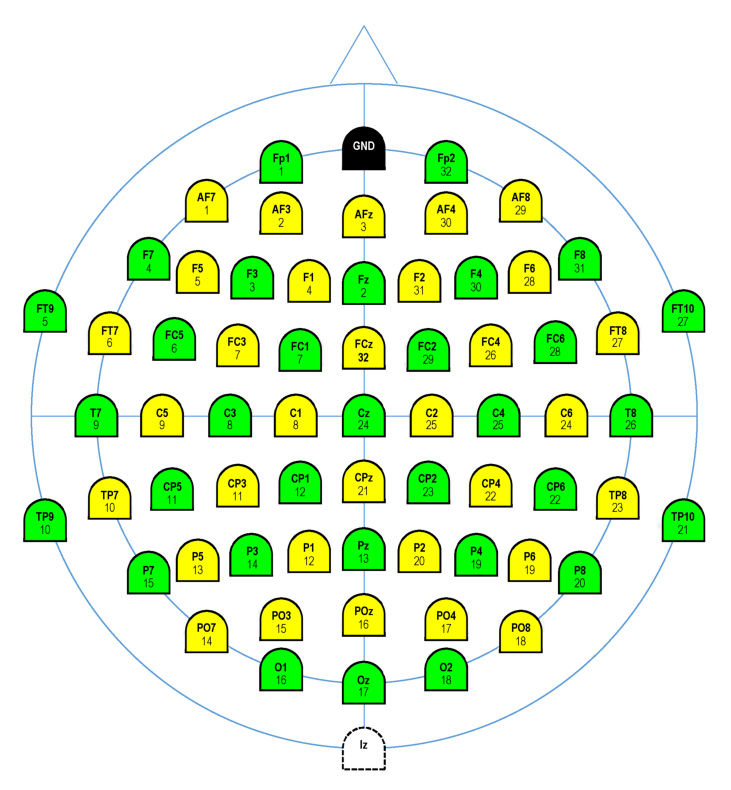

In [16]:
!wget https://komazawa-deep-learning.github.io/2024assets/ASP-64.png -O ASP-64.png
eeg_channels_img = PIL.Image.open('./ASP-64.png')
plt.figure(figsize=(10,10))
plt.axis(False)
plt.imshow(eeg_channels_img)

In [18]:
if isColab:
    eeg_basedir = '/content/drive/Shareddrives/#2024認知心理学研究(1)b/浅川先生/2023Karapetian+OSF/EEG/Preprocessed'
else:
    eeg_basedir = os.path.join(HOME, 'study/2024Agnessa14_Perceptual-decision-making.git/EEG/Preprocessed')

fname = 'sub35/timelock_categorization.mat'
s_cat = scipy.io.loadmat(os.path.join(eeg_basedir,fname))
print(f"scat['timelock'].shape:{s_cat['timelock'].shape}")   # (1,1)
print(f"scat['timelock'][0].shape:{s_cat['timelock'][0].shape}") # (1,)
print(f"len(s_cat['timelock'][0][0]):{len(s_cat['timelock'][0][0])}") # 7
# この 7 つのデータは，time, label, sampleinfo, trial, trialinfo, dimord, cfg らしい。
for i, x in enumerate(s_cat['timelock'][0][0]):
    print(i, x.shape)

scat['timelock'].shape:(1, 1)
scat['timelock'][0].shape:(1,)
len(s_cat['timelock'][0][0]):7
0 (1, 200)
1 (63, 1)
2 (2133, 2)
3 (2133, 63, 200)
4 (2133, 1)
5 (1,)
6 (1, 1)


In [19]:
# `timelock` EEG data の読み込み
fnames = sorted(glob.glob(os.path.join(eeg_basedir,'sub*/timelock_categorization.mat')))
n_subs = len(fnames)
Data = {}
for fname in fnames:
    sub_idx = fname.replace(eeg_basedir, '').split('/')[1]
    s_cat = scipy.io.loadmat(fname)['timelock'][0][0]
    trials = s_cat[3]
    stim_ord = [x[0] for x in s_cat[4]]
    channels = [str(x[0][0]) for x in s_cat[1]]
    print(f'sub_idx:{sub_idx}',
          f'trials.shape:{trials.shape}',
          f'len(channels):{len(channels)}',
          f'len(stim_ord):{len(stim_ord)}', # trialinfo
         )
    Data[sub_idx] = {}
    Data[sub_idx]['trials'] = trials
    Data[sub_idx]['channels'] = channels
    Data[sub_idx]['stim_order'] = stim_ord

print('# データは，被験者 X 試行 X EEG チャンネル X 時刻刻み という 4 次元超直方体になっている' )
print(f'list(Data.keys()):{list(Data.keys())}')

sub_idx:sub05 trials.shape:(2454, 60, 200) len(channels):60 len(stim_ord):2454
sub_idx:sub06 trials.shape:(2343, 63, 200) len(channels):63 len(stim_ord):2343
sub_idx:sub07 trials.shape:(2224, 63, 200) len(channels):63 len(stim_ord):2224
sub_idx:sub08 trials.shape:(2142, 62, 200) len(channels):62 len(stim_ord):2142
sub_idx:sub09 trials.shape:(2131, 63, 200) len(channels):63 len(stim_ord):2131
sub_idx:sub10 trials.shape:(2092, 63, 200) len(channels):63 len(stim_ord):2092
sub_idx:sub11 trials.shape:(1976, 62, 200) len(channels):62 len(stim_ord):1976
sub_idx:sub12 trials.shape:(2365, 62, 200) len(channels):62 len(stim_ord):2365
sub_idx:sub13 trials.shape:(2401, 63, 200) len(channels):63 len(stim_ord):2401
sub_idx:sub14 trials.shape:(2029, 62, 200) len(channels):62 len(stim_ord):2029
sub_idx:sub15 trials.shape:(2468, 62, 200) len(channels):62 len(stim_ord):2468
sub_idx:sub16 trials.shape:(2042, 62, 200) len(channels):62 len(stim_ord):2042
sub_idx:sub17 trials.shape:(1796, 62, 200) len(chann

In [20]:
# 各被験者は刺激画像を複数回提示されている。
# その各試行で同一刺激画像である場合を潰して，被験者毎 X 刺激画像番号毎に集計
Sub_Img = {}
for sub_idx, val in Data.items():
    Sub_Img[sub_idx] = {}
    for idx, stim_no in enumerate(val['stim_order']):
        if not stim_no in Sub_Img[sub_idx]:
            Sub_Img[sub_idx][stim_no] = []
        Sub_Img[sub_idx][stim_no].append(val['trials'][idx])
    for stim_no in sorted(Sub_Img[sub_idx].keys()):
        X = np.array(Sub_Img[sub_idx][stim_no]).mean(axis=0)
        Sub_Img[sub_idx][stim_no] = X


In [21]:
# 被験者を潰して，刺激画像 X EEG チャンネル X 時刻刻みのデータを作成

from collections import OrderedDict
Stim_sum = OrderedDict()
Stim_Chn = OrderedDict()
for idx, sub_idx in enumerate(list(Sub_Img.keys())):

    # 各被験者 sub_idx の各刺激画像 stim_no について
    for stim_no in list(Sub_Img[sub_idx].keys()):
        if not stim_no in Stim_sum:
            Stim_sum[stim_no] = []
        Stim_sum[stim_no].append(Sub_Img[sub_idx][stim_no])

        if not stim_no in Stim_Chn:
            Stim_Chn[stim_no] = OrderedDict()

        # 各刺激画像毎 EEG チャンネルごとに
        for idx, chn in enumerate(Data[sub_idx]['channels']):
            if not chn in Stim_Chn[stim_no]:
                Stim_Chn[stim_no][chn] = []
            Stim_Chn[stim_no][chn].append(Sub_Img[sub_idx][stim_no][idx])

# channels_p = ['Fp1', 'Fp2', 'AF7','AF3','AFz','AF4','AF8',
#               'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8',
#               'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10',
#               'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8',
#               'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10',
#               'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
#               'PO7', 'PO3', 'POz', 'PO4', 'PO8',
#               'O1', 'Oz', 'O2']

np.array(Stim_Chn[01][PO3]).reshape(-1).shape:(6000,)
np.array(Stim_Chn[02][PO3]).reshape(-1).shape:(6000,)
np.array(Stim_Chn[03][PO3]).reshape(-1).shape:(6000,)
len(channels):63
['AF3', 'AF4', 'AF7', 'AF8', 'AFz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCz', 'FT10', 'FT7', 'FT8', 'FT9', 'Fp1', 'Fp2', 'O1', 'O2', 'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'Pz', 'T7', 'T8', 'TP10', 'TP7', 'TP8', 'TP9']
len(Stim_Chn):60


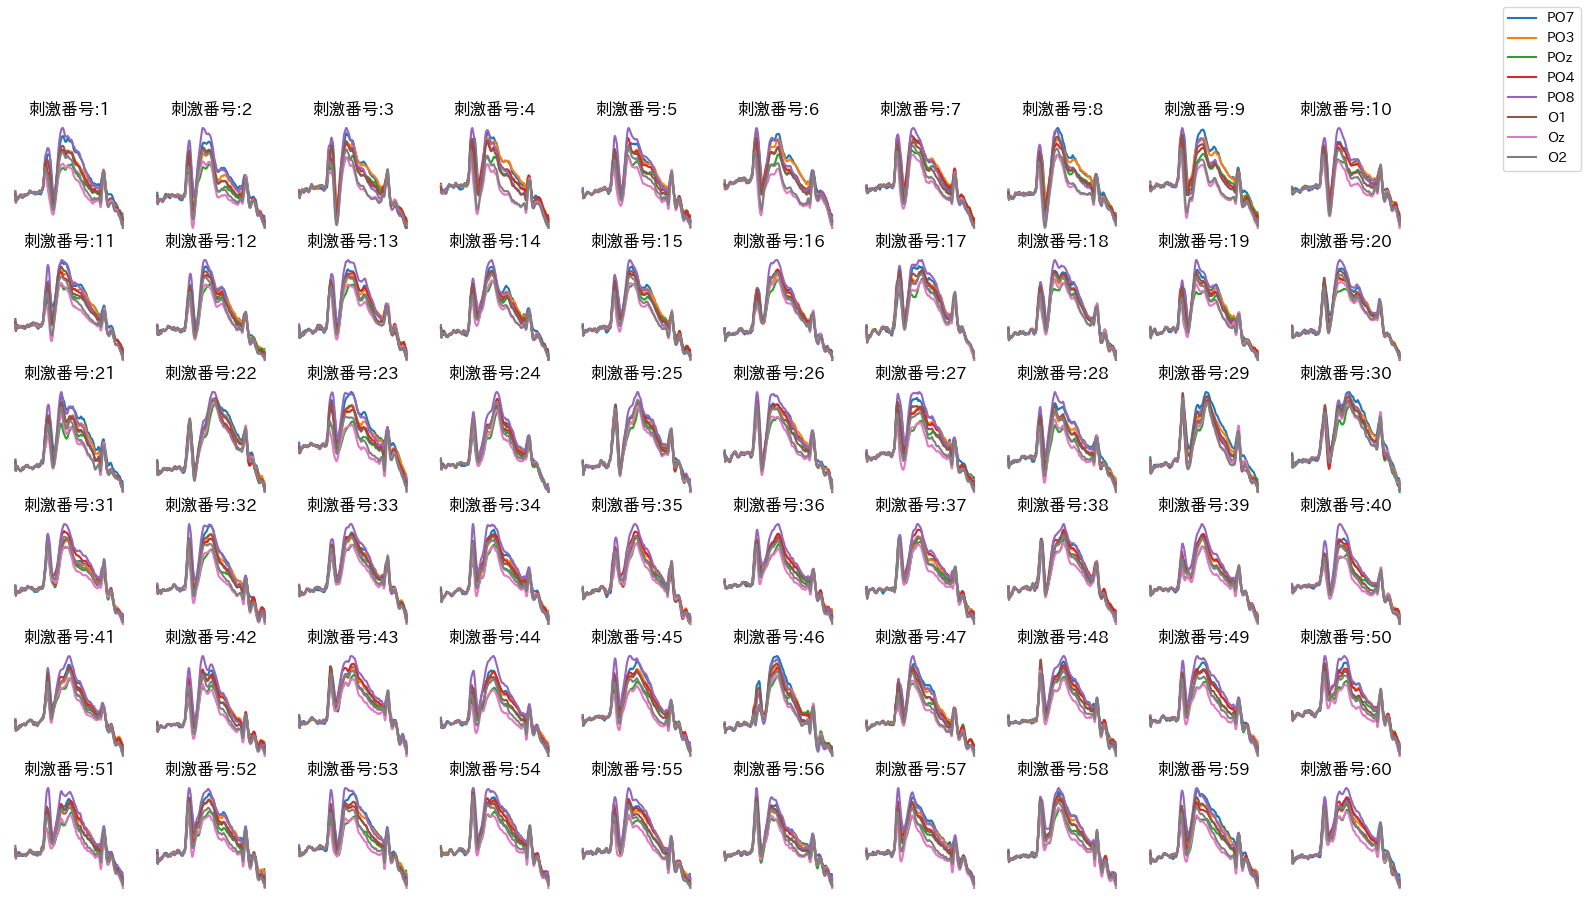

In [22]:
channels =  [#'Fp1', 'Fp2', 'AF7','AF3','AFz','AF4','AF8',
             #'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8',
             #'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10',
             #'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8',
             #'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10',
             #'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
             'PO7', 'PO3', 'POz', 'PO4', 'PO8',
             'O1', 'Oz', 'O2'
             ]

#channels_p.reverse()
#nrows, ncols = 12, 5
nrows, ncols = 6, 10
#figsize = (18, 18)
figsize = (18, 10)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
legends = []
row, col = 0, 0
for stim_no in list(sorted(Sub_Img[sub_idx].keys())):
    for chn in channels:
        X = np.mean(np.array(Stim_Chn[stim_no][chn]), axis=0)
        axes[row][col].plot(X)
        axes[row][col].set_title(f'刺激番号:{stim_no}')
        axes[row][col].axis(False)

    col += 1
    if col > ncols-1:
        col = 0
        row += 1
fig.legend(channels)
plt.show()


データ行列のサイズ:(60, 9600)


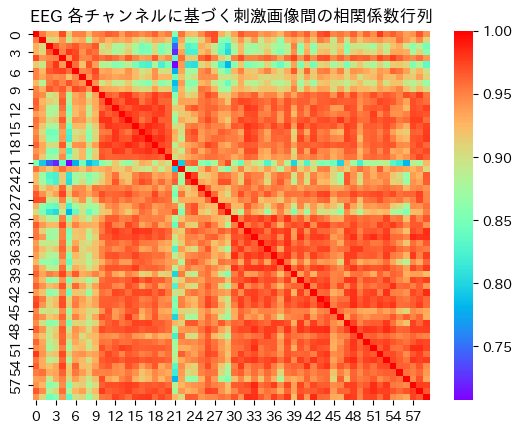

In [66]:
channels =  [#'Fp1', 'Fp2', 'AF7','AF3','AFz','AF4','AF8',
             #'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8',
             'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10',
             'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8',
             'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10',
             'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
             'PO7', 'PO3', 'POz', 'PO4', 'PO8',
             'O1', 'Oz', 'O2'
             ]
_Stim_Chn = {}
for stim_no in list(sorted(Sub_Img[sub_idx].keys())):
    _Stim_Chn[stim_no] = []
    for chn in channels:
        tmp = np.mean(np.array(Stim_Chn[stim_no][chn]), axis=0)
        _Stim_Chn[stim_no].append(tmp)
    _Stim_Chn[stim_no] = np.array(_Stim_Chn[stim_no]).reshape(-1)

X = np.array([v for k, v in _Stim_Chn.items()])

print(f'データ行列のサイズ:{X.shape}')
R_EEG = np.corrcoef(X)
ax = plt.axes()
seaborn.heatmap(R_EEG, ax=ax, cmap=cmap)
ax.set_title('EEG 各チャンネルに基づく刺激画像間の相関係数行列')
plt.show()

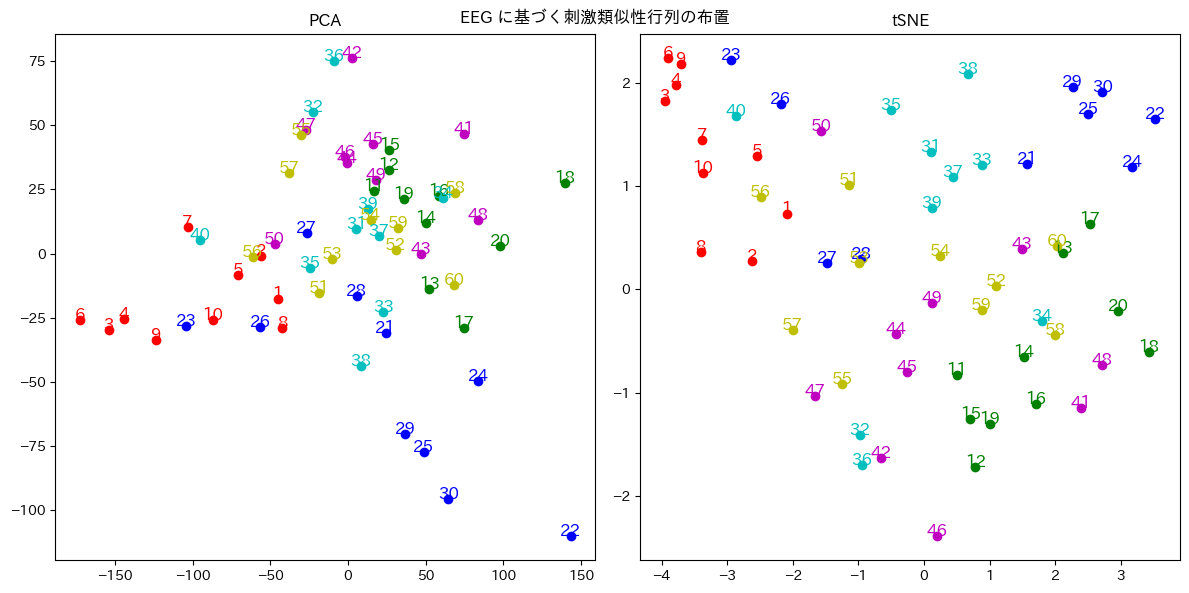

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#fig, axes = plt.subplots(1, 2, figsize=(8, 4))
colors = ['r','g', 'b', 'c', 'm', 'y']
fontsize=12
pca = PCA(n_components=2)
A = pca.fit(X)
A2 = pca.transform(X)
for idx, z in enumerate(A2):
    color = colors[int(idx / 10)]
    axes[0].scatter(z[0], z[1], c=color)
    axes[0].annotate(str(idx+1), (z[0], z[1]), ha='center', fontsize=fontsize, c=color)
axes[0].set_title('PCA')

A2 = TSNE().fit_transform(X)
for idx, z in enumerate(A2):
    color = colors[int(idx / 10)]
    axes[1].scatter(z[0], z[1], c=color)
    axes[1].annotate(str(idx+1), (z[0], z[1]), ha='center', fontsize=fontsize, c=color)
axes[1].set_title('tSNE')
fig.tight_layout()
fig.suptitle('EEG に基づく刺激類似性行列の布置')
plt.show()